<a href="https://colab.research.google.com/github/alex-w-yoo/retail-sales-eda-py/blob/main/CS667_Project1_Alex_Yoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project1 - CS667 – Practical Data Science (CRN: 72872) - Alexander YOO**

In [ ]:
import os
import sys
import math
import warnings
warnings.filterwarnings("ignore")

!pip install holidays
import holidays

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## 1) Load Data


In [ ]:
FILE_PATH = "/content/sample_data/retail_sales.xlsx"
assert os.path.exists(FILE_PATH), f"File not found at {FILE_PATH}"

xls = pd.ExcelFile(FILE_PATH)
dfs = []
for s in xls.sheet_names:
    df_tmp = pd.read_excel(FILE_PATH, sheet_name=s)
    df_tmp["__sheet__"] = s
    dfs.append(df_tmp)
df = pd.concat(dfs, ignore_index=True)

print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

Loaded shape: (1000, 10)
Columns: ['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount', '__sheet__']
   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   

   Quantity  Price per Unit  Total Amount             __sheet__  
0         3              50           150  retail_sales_dataset  
1         2             500          1000  retail_sales_dataset  
2         1              30            30  retail_sales_dataset  


## 2) Data Cleaning / Preparation




In [ ]:
def to_snake(s):
    return (
        str(s)
        .strip()
        .replace("#", "num")
        .replace("%", "pct")
        .replace("/", "_")
        .replace("-", "_")
        .replace(" ", "_")
        .lower()
    )
df.columns = [to_snake(c) for c in df.columns]

col_map_candidates = {
    "transaction_id": ["transaction_id", "trans_id", "id", "transaction"],
    "date": ["date", "order_date", "transaction_date", "datetime"],
    "customer_id": ["customer_id", "cust_id", "user_id", "client_id"],
    "gender": ["gender", "sex"],
    "age": ["age", "customer_age"],
    "product_category": ["product_category", "category", "product_cat", "productgroup"],
    "quantity": ["quantity", "qty", "units"],
    "price_per_unit": ["price_per_unit", "unit_price", "price"],
    "total_amount": ["total_amount", "amount", "total", "sales", "revenue"],
}

resolved = {}
for std_name, variants in col_map_candidates.items():
    for v in variants:
        if v in df.columns:
            resolved[std_name] = v
            break

for std_name in col_map_candidates.keys():
    if std_name not in resolved:
        print(f"[WARN] Could not resolve column for '{std_name}'. You'll need to adjust manually if it's truly missing.")
        resolved[std_name] = None

def col(name):
    key = resolved.get(name)
    return key if (key is not None and key in df.columns) else None


In [ ]:
from sklearn.impute import KNNImputer

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
safe_num_cols = [c for c in num_cols if c not in []]

if len(safe_num_cols) > 0:
    imputer = KNNImputer(n_neighbors=5)
    df[safe_num_cols] = imputer.fit_transform(df[safe_num_cols])

## 3) Data Cleaning II — Type Casting, Missing-Value Handling & De-duplication


In [ ]:
date_col = col("date")
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
else:
    df["__fake_date__"] = pd.date_range("2023-01-01", periods=len(df), freq="D")
    resolved["date"] = "__fake_date__"
    date_col = "__fake_date__"

for num_col_std in ["age", "quantity", "price_per_unit", "total_amount"]:
    c = col(num_col_std)
    if c:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if col("total_amount") is None and col("quantity") and col("price_per_unit"):
    df["total_amount"] = df[col("quantity")] * df[col("price_per_unit")]
    resolved["total_amount"] = "total_amount"

before_dup = len(df)
df = df.drop_duplicates()
print(f"Removed {before_dup - len(df)} duplicate rows")

missing_summary = df.isna().sum().sort_values(ascending=False)
print("\nMissing Values per Column:\n", missing_summary)

if col("age"):
    df[col("age")] = df[col("age")].fillna(df[col("age")].median())

critical = [date_col, col("total_amount")]
critical = [c for c in critical if c is not None]
df = df.dropna(subset=critical)

Removed 0 duplicate rows

Missing Values per Column:
 transaction_id      0
date                0
customer_id         0
gender              0
age                 0
product_category    0
quantity            0
price_per_unit      0
total_amount        0
__sheet__           0
dtype: int64


## 4) Feature Engineering — Time Features & US Holiday Flag


In [ ]:
d = date_col
df["year"] = df[d].dt.year
df["quarter"] = df[d].dt.quarter
df["month"] = df[d].dt.month
df["day"] = df[d].dt.day
df["dayofweek"] = df[d].dt.dayofweek  # Monday=0
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["weekofyear"] = df[d].dt.isocalendar().week.astype(int)

def add_holiday_flag(frame, date_field, country="US"):
    if holidays is None:
        frame["is_holiday"] = 0
        return frame
    try:
        years = frame[date_field].dt.year.unique().tolist()
        if country == "US":
            hol = holidays.UnitedStates(years=years)
        elif country == "KR":
            hol = holidays.Korea(years=years)
        else:
            hol = holidays.UnitedStates(years=years)
        frame["is_holiday"] = frame[date_field].dt.date.astype(object).isin(hol).astype(int)
    except Exception:
        frame["is_holiday"] = 0
    return frame

df = add_holiday_flag(df, d, country="US")

## 5) Advanced EDA — Time Series Sales Analysis


In [ ]:
target = col("total_amount")
qty = col("quantity")
price = col("price_per_unit")
cat = col("product_category")
gender = col("gender")

# Daily and Monthly sales
daily_sales = df.groupby(df[d].dt.to_period("D"))[target].sum().to_timestamp()
monthly_sales = df.groupby(df[d].dt.to_period("M"))[target].sum().to_timestamp()

print("\nHead (daily_sales):\n", daily_sales.head())
print("\nHead (monthly_sales):\n", monthly_sales.head())


Head (daily_sales):
 date
2023-01-01    3600
2023-01-02    1765
2023-01-03     600
2023-01-04    1240
2023-01-05    1100
Name: total_amount, dtype: int64

Head (monthly_sales):
 date
2023-01-01    35450
2023-02-01    44060
2023-03-01    28990
2023-04-01    33870
2023-05-01    53150
Freq: MS, Name: total_amount, dtype: int64


## 6) Advanced EDA — Outlier Detection (IQR on Total Amount)


In [ ]:

Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["is_outlier_total"] = ((df[target] < lower) | (df[target] > upper)).astype(int)
print(f"\nOutlier bounds for {target}: [{lower:,.2f}, {upper:,.2f}]")
print("Outlier rate:", df["is_outlier_total"].mean().round(4))


Outlier bounds for total_amount: [-1,200.00, 2,160.00]
Outlier rate: 0.0


In [ ]:
# Daily anomalies via z-score
daily = df.groupby('date')[target].sum().rename('sales').to_frame()
daily['z'] = (daily['sales'] - daily['sales'].mean()) / daily['sales'].std()
anomalies = daily[(daily['z'].abs() >= 3)].sort_values('z', ascending=False).head(10)
print("Top daily anomalies (|z|>=3):\n", anomalies)

Top daily anomalies (|z|>=3):
             sales         z
date                       
2023-05-23   8455  5.836660
2023-05-16   7260  4.858873
2023-06-24   6220  4.007912
2023-02-17   5890  3.737896
2023-08-05   5205  3.177407
2023-07-14   5125  3.111948


## 7) Feature Engineering — Customer-Level Rolling & EWM Features


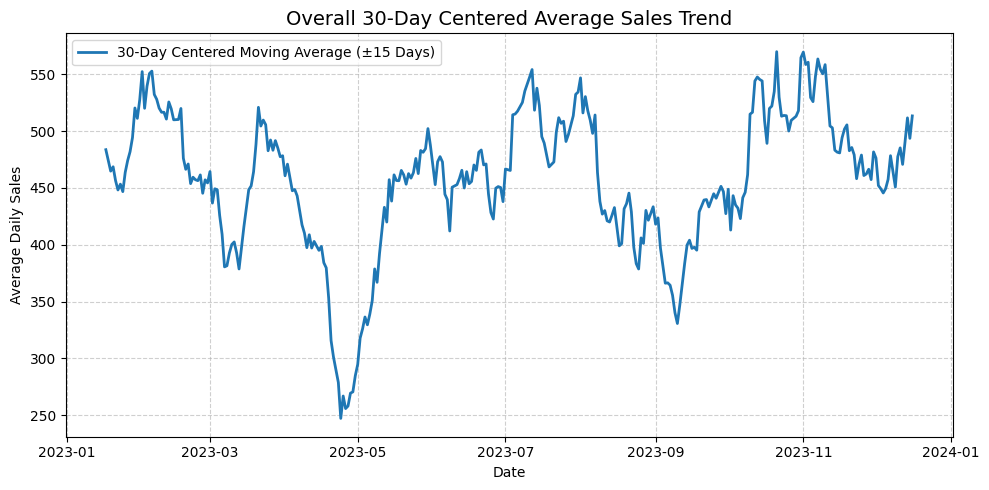

In [44]:
daily_mean_sales = (
    df.groupby(df[d].dt.to_period("D"))[target]
      .mean()
      .to_timestamp()
)

rolling_30d_centered_mean = daily_mean_sales.rolling(window=31, center=True).mean()

plt.figure(figsize=(10, 5))
plt.plot(rolling_30d_centered_mean, label="30-Day Centered Moving Average (±15 Days)",
         color="tab:blue", linewidth=2)
plt.title("Overall 30-Day Centered Average Sales Trend", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Daily Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## 8) Feature Engineering — Target Encoding for Categorical Variables

In [ ]:
global_mean = df[target].mean()

def target_encode(series, y, min_samples_leaf=10, smoothing=5):
    stats = y.groupby(series).agg(["mean", "count"])
    weight = 1 / (1 + np.exp(-(stats["count"] - min_samples_leaf) / smoothing))
    enc = weight * stats["mean"] + (1 - weight) * global_mean
    return series.map(enc).fillna(global_mean)

## 9) Advanced EDA — Visualization & Business Insights

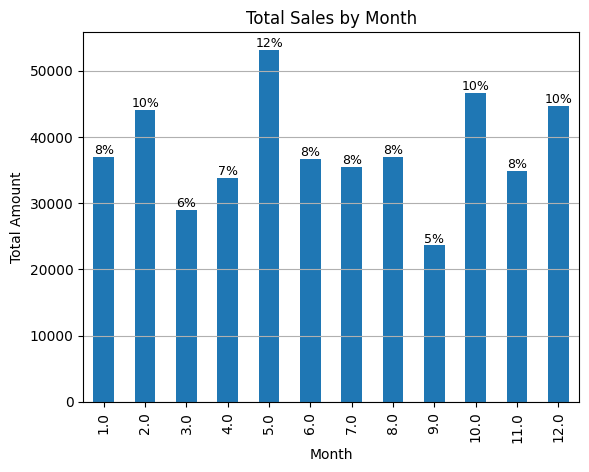

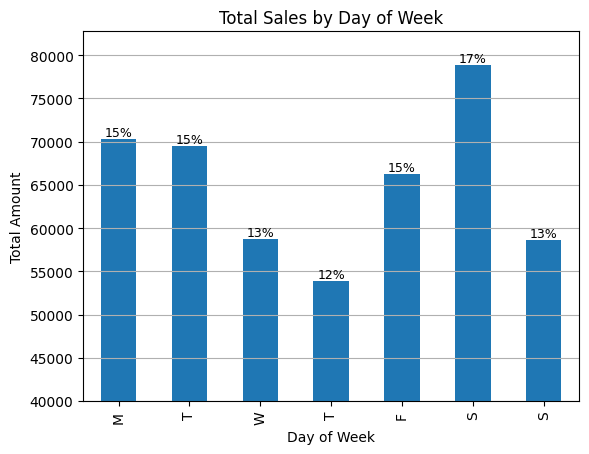

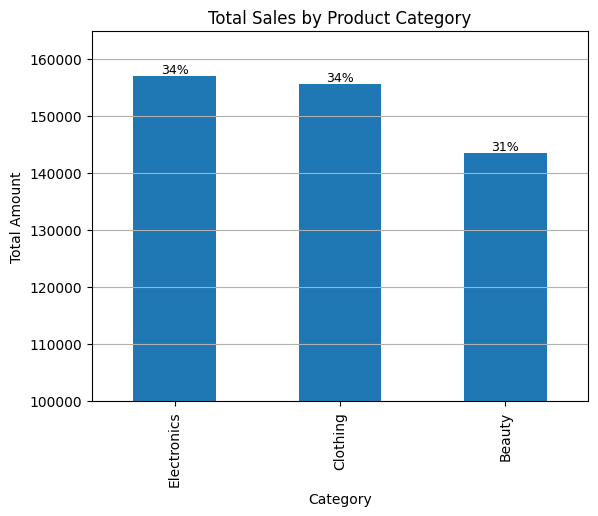

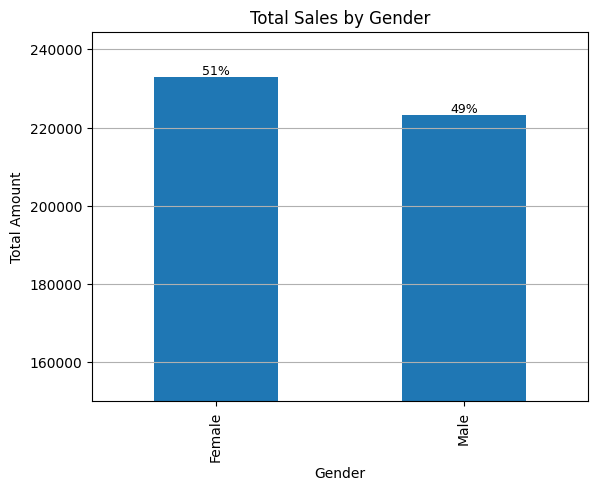

In [ ]:
# (A) Sales by Month (Seasonality)
sales_by_month = df.groupby("month")[target].sum()
total_month = sales_by_month.sum()
plt.figure()
ax = sales_by_month.plot(kind="bar")
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.grid(True, axis="y")

for p in ax.patches:
    percentage = (p.get_height() / total_month) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f"{int(round(percentage))}%",
        ha="center",
        va="bottom",
        fontsize=9
    )
plt.show()

# (B) Weekday pattern
sales_by_dow = df.groupby("dayofweek")[target].sum()
total_dow = sales_by_dow.sum()
plt.figure()
ax = sales_by_dow.plot(kind="bar")
plt.title("Total Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Amount")
plt.xticks(ticks=range(7), labels=["M", "T", "W", "T", "F", "S", "S"])
plt.ylim(40000, None)
plt.grid(True, axis="y")

for p in ax.patches:
    percentage = (p.get_height() / total_dow) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f"{int(round(percentage))}%",
        ha="center",
        va="bottom",
        fontsize=9
    )
plt.show()

# (C) Category contribution
if cat:
    sales_by_cat = df.groupby(cat)[target].sum().sort_values(ascending=False)
    total_cat = sales_by_cat.sum()
    plt.figure()
    ax = sales_by_cat.plot(kind="bar")
    plt.title("Total Sales by Product Category")
    plt.xlabel("Category")
    plt.ylabel("Total Amount")
    plt.ylim(100000, None)
    plt.grid(True, axis="y")

    for p in ax.patches:
        percentage = (p.get_height() / total_cat) * 100
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{int(round(percentage))}%",
            ha="center",
            va="bottom",
            fontsize=9
        )
    plt.show()

# (D) Gender split (if present)
if gender:
    sales_by_gender = df.groupby(gender)[target].sum()
    total_gender = sales_by_gender.sum()
    plt.figure()
    ax = sales_by_gender.plot(kind="bar")
    plt.title("Total Sales by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Total Amount")
    plt.ylim(150000, None)
    plt.grid(True, axis="y")

    for p in ax.patches:
        percentage = (p.get_height() / total_gender) * 100
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{int(round(percentage))}%",
            ha="center",
            va="bottom",
            fontsize=9
        )
    plt.show()

## 10) Feature Engineering — Time-based Features and US Holiday Flag

In [ ]:
d = date_col
df["year"] = df[d].dt.year
df["quarter"] = df[d].dt.quarter
df["month"] = df[d].dt.month
df["day"] = df[d].dt.day
df["dayofweek"] = df[d].dt.dayofweek  # Monday=0
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["weekofyear"] = df[d].dt.isocalendar().week.astype(int)

def add_holiday_flag(frame, date_field, country="US"):
    try:
        years = frame[date_field].dt.year.unique().tolist()
        if country == "US":
            hol = holidays.UnitedStates(years=years)
        elif country == "KR":
            hol = holidays.Korea(years=years)
        else:
            hol = holidays.UnitedStates(years=years)
        frame["is_holiday"] = frame[date_field].dt.date.astype(object).isin(hol).astype(int)
    except Exception:
        frame["is_holiday"] = 0
    return frame

df = add_holiday_flag(df, d, country="US")

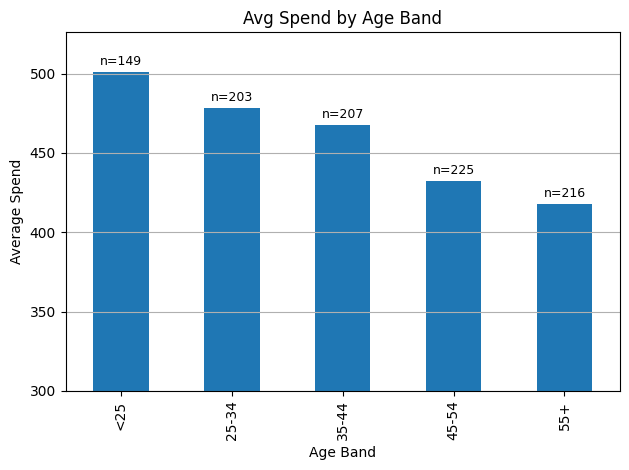

In [39]:
age_col = col("age")
assert age_col is not None, " "

tmp = df.dropna(subset=[age_col, target]).copy()

bins = [-np.inf, 24, 34, 44, 54, np.inf]
labels = ['<25','25-34','35-44','45-54','55+']
tmp['age_band'] = pd.cut(tmp[age_col], bins=bins, labels=labels, right=True, include_lowest=True)

age_stats = (
    tmp.groupby('age_band')[target]
       .agg(mean='mean', count='count')
       .reindex(labels)
)

ax = age_stats['mean'].plot(kind='bar')
ax.set_title('Avg Spend by Age Band')
ax.set_xlabel('Age Band')
ax.set_ylabel('Average Spend')
ax.grid(True, axis='y')

for p, n in zip(ax.patches, age_stats['count'].fillna(0).astype(int).tolist()):
    ax.annotate(f'n={n}',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.ylim(300, None)
plt.show()

## 11) Correlation Analysis — Numeric Feature Relationships


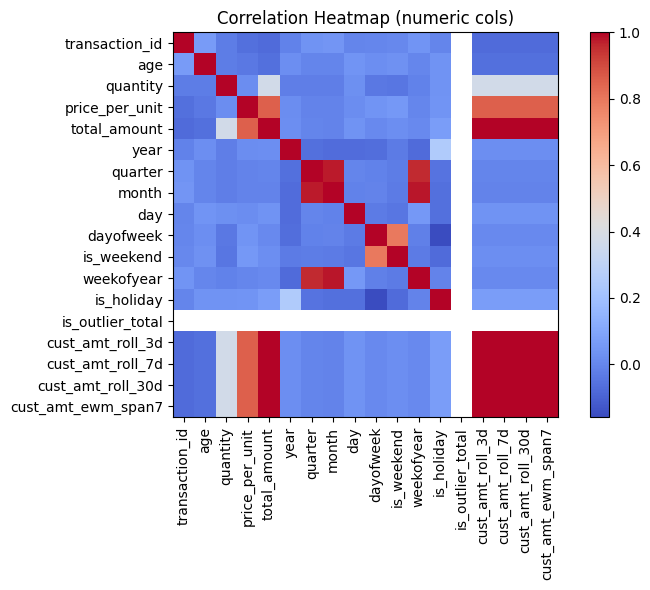

In [41]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap (numeric cols)")

im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")

plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

plt.colorbar(im)

plt.tight_layout()
plt.show()

## 12) Holiday Impact Analysis — Average Daily Sales Lift


                   mean  median  count
is_holiday                            
0           1310.933735  1030.0    332
1           1597.692308  1200.0     13

Avg sales lift on holidays: 21.9%


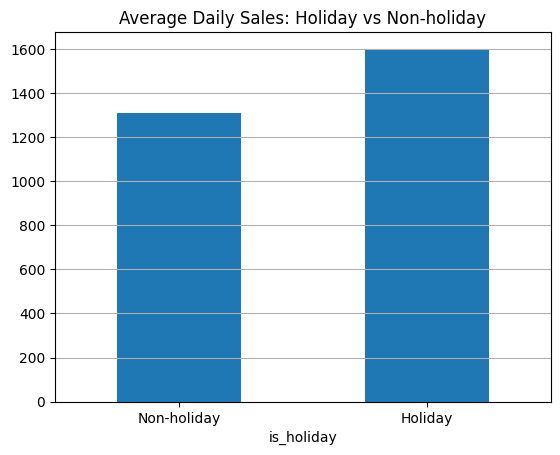

In [42]:
# Holiday impact: avg daily sales lift
day_sales = df.groupby('date')[target].sum().reset_index()
day_sales['is_holiday'] = df.groupby('date')['is_holiday'].max().values  # 일자 단위 플래그
summary = day_sales.groupby('is_holiday')[target].agg(['mean','median','count'])
lift = (summary.loc[1,'mean'] / summary.loc[0,'mean'] - 1) * 100
print(summary)
print(f"\nAvg sales lift on holidays: {lift:.1f}%")

# (선택) 시각화
ax = summary['mean'].plot(kind='bar')
ax.set_xticklabels(['Non-holiday','Holiday'], rotation=0)
plt.title('Average Daily Sales: Holiday vs Non-holiday')
plt.grid(True, axis='y'); plt.show()



---

# 13) Conclusion — Key Business Recommendations

- Wed (13%) & Thu (12%) are weak → add midweek discounts.

- Mar (6%) & Sep (5%) → run monthly promos.

- Under-25 spend USD 500 (+20%) vs 55+ USD 420 — target TikTok/Instagram.

- Holidays +20% sales — add ~20% staff.





---

